# Example of gridded forecasts postprocessing

In this example, using Pythie, we postprocess the 2 metre temperature forecasts at a station. We postprocess it with the 2 metre temperature itself, the maximum 2 metre temperature in the last 6 hours and the soil temperature as predictors.

We use the [ERA5 reanalysis](https://climate.copernicus.eu/climate-reanalysis) over a large area in Europe from 1997 to 2016 as gridded observations. These reanalysis have been downloaded from the [Copernicus Data Store](https://cds.climate.copernicus.eu) and converted to the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) file format.

The postprocessing is done by making a regression, at each grid point and lead time, between the gridded reforecasts and the gridded reanalysis (considered as observation). For verification, the result of this regression is then applied on the reforecasts themselves (the training set).

The reforecasts files have been download from [ECMWF](https://www.ecmwf.int/) and converted to NetCDF files.

**Note:** *In the following example, we drop the initial conditions of the reforecasts because one of the maximum 2 meter temperature is not defined at this lead time ! As a result, we do not postprocess the lead time 0.*

**Gridded reforecast data source**

Source: [www.ecmwf.int](https://www.ecmwf.int/)

Creative Commons Attribution 4.0 International (CC BY 4.0)
Copyright © 2021 European Centre for Medium-Range Weather Forecasts (ECMWF).
See the attached ECMWF_LICENSE.txt file included with the data for more details.

**Copernicus ERA5 gridded reanalysis data source**

Source: [https://cds.climate.copernicus.eu/](https://cds.climate.copernicus.eu/)

Copyright © 2021 European Union.
Generated using Copernicus Climate Change Service information 2021.

Hersbach et al. (2018): ERA5 hourly data on single levels from 1979 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). (Accessed on < 21-04-2021 >), [doi:10.24381/cds.adbb2d47](https://doi.org/10.24381/cds.adbb2d47).

See the attached COPERNICUS_LICENSE.txt file included with the data for more details.

## Preliminaries

Setting the path

In [1]:
import sys, os
sys.path.extend([os.path.abspath('../../../../')])
os.chdir('../../../../')

Importing external modules

In [2]:
import iris
import iris.pandas as ipd
import iris.plot as iplt
import iris.quickplot as qplt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import cftime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
from IPython.display import HTML

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':16})

In [4]:
%matplotlib inline

Importing internal modules

In [5]:
from core.data import Data
import postprocessors.MBM as MBM


Setting some parameters

In [6]:
# Date of the forecast
date = "01-02"
# Year to correct
year = 2017
# Number of reforecasts
years_back = 20
# Parameter of the analysis (to be postprocessed)
param = '2t'
# Parameters of the predictors
params = ['2t', 'mx2t6', 'stl1']
# Time units used in the NetCDF input files
time_units = 'hours since 1900-01-01 00:00:00.0'
# Locaction of the data
data_folder = './data/europa_grid/'


Defining some functions to extract the time coordinates from Iris cubes

In [7]:
def get_cubes_time_index(cubes):
    # assumes all the cube in cubes have the same timestamps
    a = ipd.as_data_frame(cubes[0][:, 0, 0])
    return a.index


def get_cubes_time(cubes, units=None, year=None):
    time_index = get_cubes_time_index(cubes)
    if year is not None:
        convert_time = lambda t: datetime.datetime(year, t.month, t.day, t.hour)
    else:
        convert_time = lambda t: datetime.datetime(t.year, t.month, t.day, t.hour)
    time = np.array(list(map(convert_time, time_index.values)), dtype=object)
    if units is not None:
        cf_time = cftime.date2num(time, units=units)
        return time, cf_time
    else:
        return time, None


Defining some plotting functions

In [8]:
def plot_cube(cube, t, v, ax=None, quick=True):
    if ax is None:
        map_proj = ccrs.PlateCarree()
        plt.figure(figsize=(15, 10))
        ax = plt.axes(projection=map_proj)
    extent = [-20, 20, 30, 70]
    ax.gridlines()
    ax.coastlines(resolution='50m')
    ax.add_feature(cartopy.feature.BORDERS)
    if quick:
        qplt.contourf(cube[t, :, :], v, axes=ax, cmap=cm.get_cmap('bwr'))
    else:
        iplt.contourf(cube[t, :, :], v, axes=ax, cmap=cm.get_cmap('bwr'))
    ax.set_extent(extent)
    return ax


def plot_quant(quant, labels, timestamps, grid_point):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca()

    first = True
    for c, lab in zip(quant, labels):
        if first:
            c.plot(ax=ax, global_label=lab, timestamps=timestamps, lw=3., ls="--", grid_point=grid_point)
            first = False
        else:
            c.plot(ax=ax, global_label=lab, timestamps=timestamps, grid_point=grid_point)

    ax.legend()
    return ax


## Loading and creating the Data objects

**This section shows how to load Data objects from NetCDF files using Iris**

First we load the reforecasts

In [9]:
# For each year in the past:
for y in range(year-years_back, year):
    # We load the reforecasts with Iris
    reforecast_cubes = iris.load(data_folder+'reforecasts_'+'-'.join(params)+'_'+str(y)+'-'+date+'.nc')
    # If it is the first year, then:
    if y == year-years_back:
        # We create one list per predictors:
        reforecasts_list = list()
        for i in range(len(reforecast_cubes)):
            reforecasts_list.append(list())
        # And a list for the timestamps:
        times = list()
    # We extract the time:
    time, t = get_cubes_time(reforecast_cubes, time_units)
    times.append(time[1:, ...])
    # We create a Numpy array for each variable from the Iris cube 
    for i, cube in enumerate(reforecast_cubes):
        # (we have to swap the time and ensemble member axis and add 2 dummy axis at the beginning 
        # to fit the Data object specs)
        data = np.array(cube.data[1:, ...]).swapaxes(0, 1)[np.newaxis, np.newaxis, ...]
        # (and also add the dummy 'variable' axis)
        data = np.expand_dims(data, 3)
        reforecasts_list[i].append(data)

# Now that the data have been loaded into convenient Numpy arrays, we can create the Data object:
# First create one Data object per predictor
reforecasts_data_list = list()
for reforecast in reforecasts_list:
    reforecasts_data_list.append(Data(np.concatenate(reforecast, axis=1), timestamps=times))
# saving the first predictor (the variable itself) for latter
reforecast_data_1st_predictor = reforecasts_data_list[0].copy()
# (Deleting data not needed anymore to save RAM space)
del reforecast_cubes, reforecasts_list
# Then loading all the predictors into one single Data object
reforecasts_data = reforecasts_data_list[0].copy()
for reforecast in reforecasts_data_list[1:]:
    reforecasts_data.append_predictors(reforecast)
# (Deleting data not needed anymore to save RAM space)
del reforecasts_data_list




Then we load the analysis

In [10]:
# Same as previously but fo only one variable
analysis = list()
times = list()
for y in range(year-years_back, year):
    analysis_cube = iris.load(data_folder+'analysis_'+param+'_'+str(y)+'-'+date+'.nc')
    time, t = get_cubes_time(analysis_cube, time_units)
    times.append(time[1:, ...])
    data = np.array(analysis_cube[0].data[1:, ...])[np.newaxis, np.newaxis, np.newaxis, np.newaxis, ...]
    analysis.append(data)

analysis_data = Data(np.concatenate(analysis, axis=1), timestamps=times)

del analysis



## Training the PostProcessors

In this section, we train the various different postprocessors of the Member-By-Member MBM module with the data previously loaded

In [11]:
# List to hold the trained PostProcessors
postprocessors = list()
proc_labels = list()

### Simple bias correction

In [12]:
ebc = MBM.BiasCorrection()
ebc.train(analysis_data, reforecasts_data)
postprocessors.append(ebc)
proc_labels.append('Bias correction')


### Ensemble Mean correction

In [13]:
emc = MBM.EnsembleMeanCorrection()
emc.train(analysis_data, reforecasts_data)
postprocessors.append(emc)
proc_labels.append('Ensemble Mean correction')


### Ensemble Spread Scaling correction

In [14]:
essc = MBM.EnsembleSpreadScalingCorrection()
essc.train(analysis_data, reforecasts_data)
postprocessors.append(essc)
proc_labels.append('Ensemble Spread Scaling correction')


### Ensemble Spread Scaling correction with Absolute norm CRPS minimization

In [15]:
essacc = MBM.EnsembleSpreadScalingAbsCRPSCorrection()
essacc.train(analysis_data, reforecasts_data, ntrial=1)
postprocessors.append(essacc)
proc_labels.append('Ensemble Spread Scaling Abs. CRPS min. correction')


### Ensemble Spread Scaling correction + Climatology nudging with Absolute norm CRPS minimization

In [16]:
eacc = MBM.EnsembleAbsCRPSCorrection()
eacc.train(analysis_data, reforecasts_data, ntrial=1)
postprocessors.append(eacc)
proc_labels.append('Ensemble Spread Scaling + Clim. Nudging Abs. CRPS min. correction')


### Ensemble Spread Scaling correction + Climatology nudging with Ngr CRPS minimization

In [17]:
encc = MBM.EnsembleNgrCRPSCorrection()
encc.train(analysis_data, reforecasts_data, ntrial=1)
postprocessors.append(encc)
proc_labels.append('Ensemble Spread Scaling + Clim. Nudging Ngr CRPS min. correction')


## Verification

Here we are going to postprocess the reforecasts themselves to see how well they perform:

In [18]:
# List to store the experiment names
exp_results = list()
exp_results.append(reforecast_data_1st_predictor)
exp_labels = list()
exp_labels.append('Raw forecasts')

In [19]:
timestamps = np.array(range(reforecast_data_1st_predictor.number_of_time_steps))

In [20]:
for label, postprocessor in zip(proc_labels, postprocessors):
    exp_results.append(postprocessor(reforecasts_data))
    exp_labels.append(label)


### Computing scores

Computing the bias

In [21]:
# List to store the CRPS Data object
bias = list()
for label, result in zip(exp_labels, exp_results):
    bias.append(result.bias(analysis_data))

Computing the ensemble mean RMSE

In [22]:
# List to store the CRPS Data object
rmse = list()
for label, result in zip(exp_labels, exp_results):
    rmse.append(result.ensemble_mean_RMSE(analysis_data))

Computing the CRPS

In [23]:
# List to store the CRPS Data object
crps = list()
for label, result in zip(exp_labels, exp_results):
    crps.append(result.CRPS(analysis_data))

### Plotting the scores

#### Plots at a grid point

In [24]:
grid_point=(20,70)

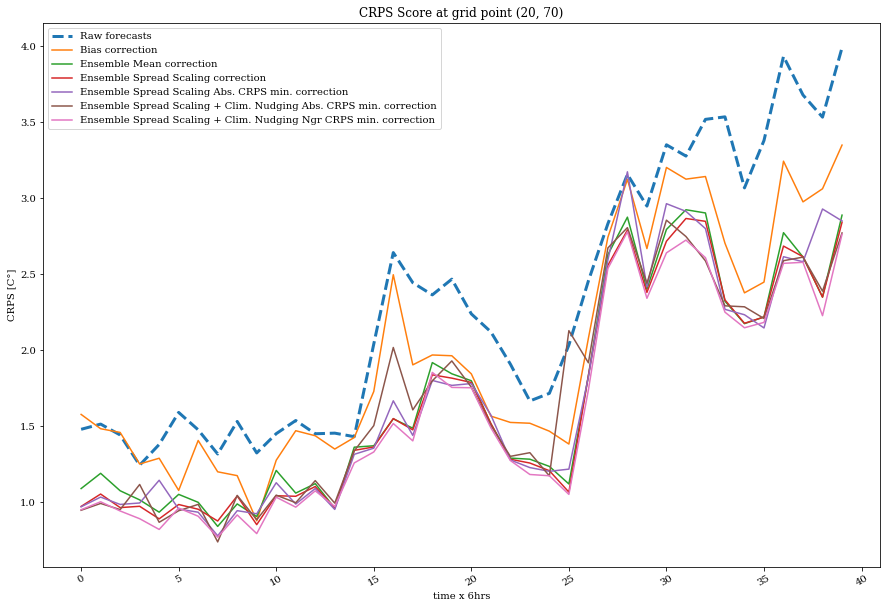

In [25]:
ax = plot_quant(crps, exp_labels, timestamps, grid_point=grid_point)
ax.set_title('CRPS Score at grid point '+str(grid_point))
ax.set_ylabel('CRPS [C°]')
ax.set_xlabel('time x 6hrs');

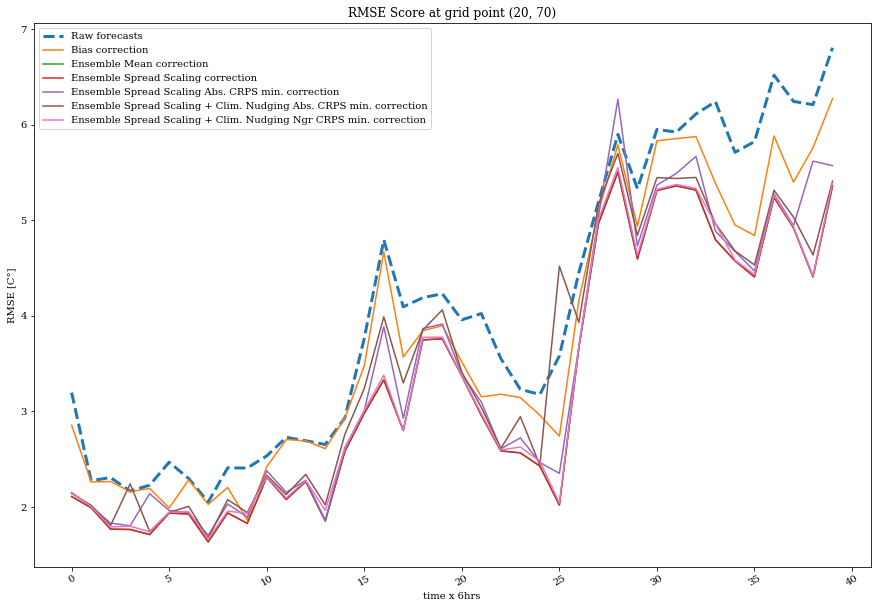

In [26]:
ax = plot_quant(rmse, exp_labels, timestamps, grid_point=grid_point)
ax.set_title('RMSE Score at grid point '+str(grid_point))
ax.set_ylabel('RMSE [C°]')
ax.set_xlabel('time x 6hrs');

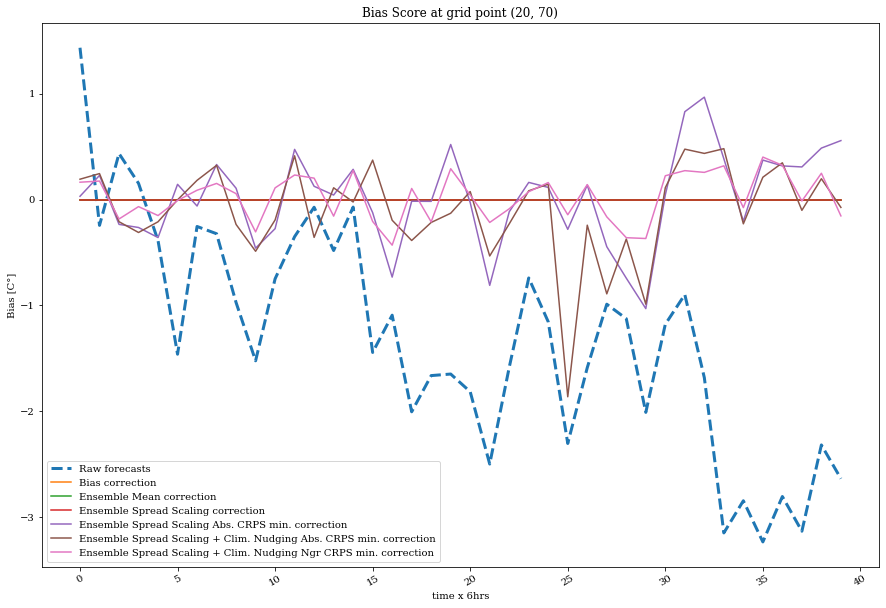

In [27]:
ax = plot_quant(bias, exp_labels, timestamps, grid_point=grid_point)
ax.set_title('Bias Score at grid point '+str(grid_point))
ax.set_ylabel('Bias [C°]')
ax.set_xlabel('time x 6hrs');

#### Plotting scores as fields

Creating Iris CubeLists to store the scores:

In [28]:
crps_cubes = iris.cube.CubeList()
bias_cubes = iris.cube.CubeList()
rmse_cubes = iris.cube.CubeList()


Creating the bias cubes

In [29]:
for score in bias:
    # Creating a cube by recycling the analysis one
    bias_cube = analysis_cube[0].copy()
    # And replacing the data inside by the score
    bias_cube.data[1:, :, :] = np.squeeze(score.data)
    bias_cubes.append(bias_cube[1:])

In [30]:
for score in rmse:
    # Creating a cube by recycling the analysis one
    rmse_cube = analysis_cube[0].copy()
    # And replacing the data inside by the score
    rmse_cube.data[1:, :, :] = np.squeeze(score.data)
    rmse_cubes.append(rmse_cube[1:])

In [31]:
for score in crps:
    # Creating a cube by recycling the analysis one
    crps_cube = analysis_cube[0].copy()
    # And replacing the data inside by the score
    crps_cube.data[1:, :, :] = np.squeeze(score.data)
    crps_cubes.append(crps_cube[1:])

In [32]:
# Countour plot levels in Celsius
t2m_range = np.arange(-4.,4.,0.25)

Plot of the CRPS improvement

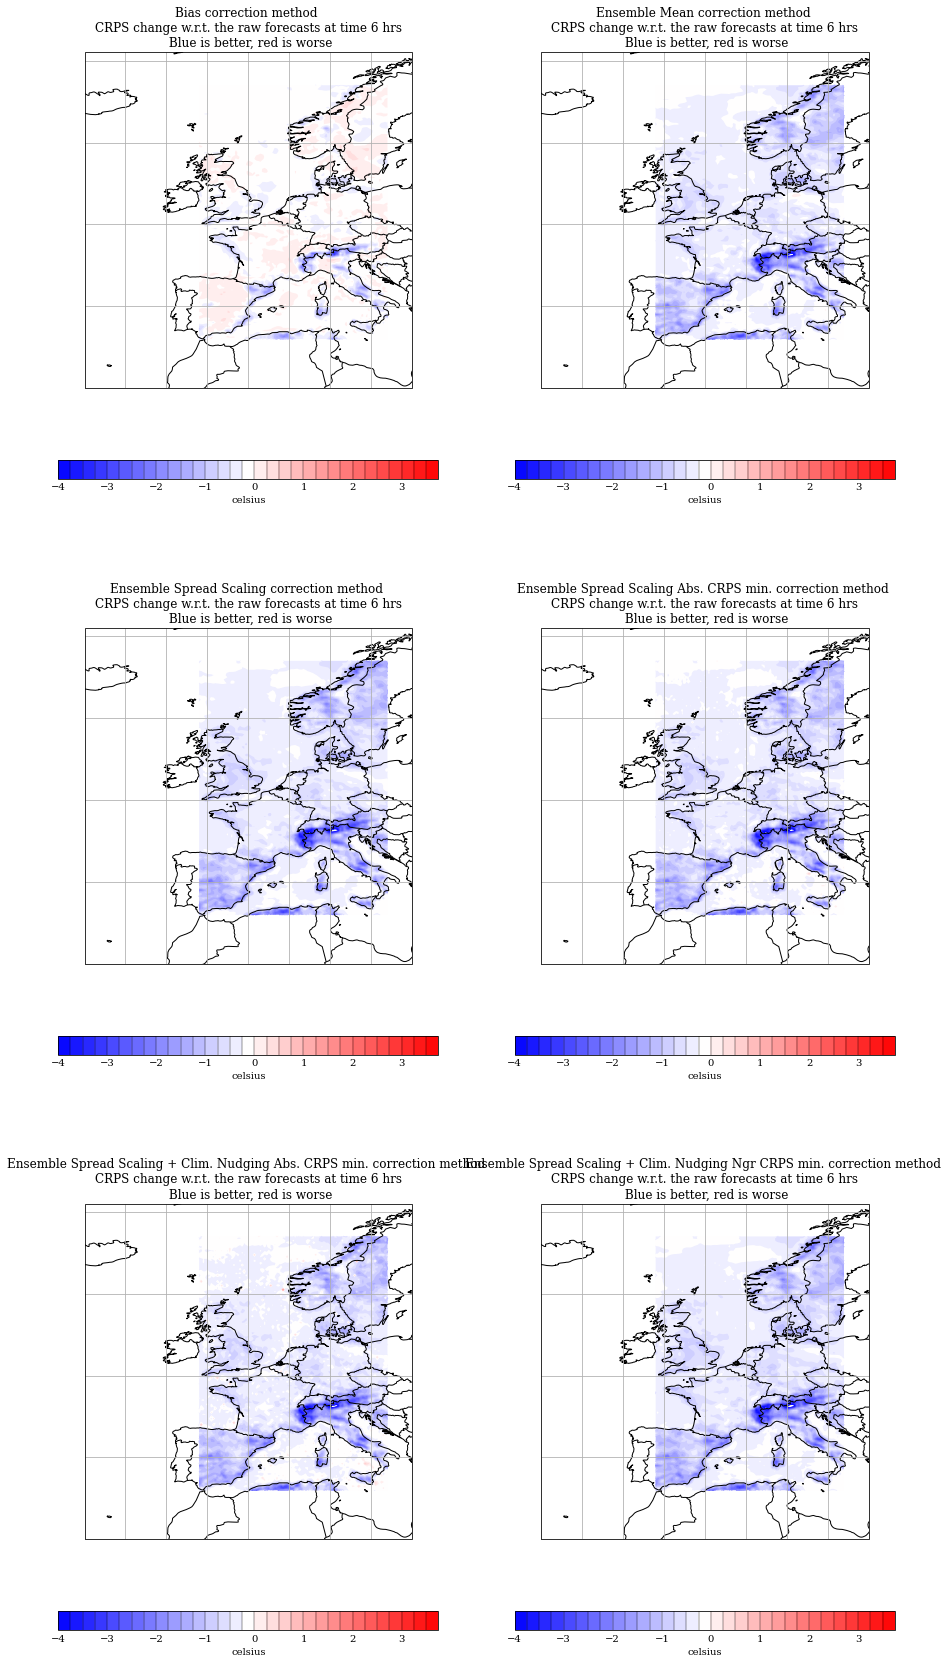

In [33]:
frames = crps_cubes[0].shape[0]
map_proj = ccrs.PlateCarree()
ns = len(rmse_cubes)-1
nr = int(np.ceil(ns / 2))
axls = list()
fig=plt.figure(figsize=(15, 10 * nr))
t = 0
for i in range(ns):
    plt.subplot(nr, 2, i+1, projection=map_proj)
    ax = plt.gca()
    axls.append(ax)
    plot_cube(crps_cubes[i+1]-crps_cubes[0], t, t2m_range, ax=ax)
    ax.set_title(exp_labels[i+1]+' method \nCRPS change w.r.t. the raw forecasts at time '+str((t+1)*6)+' hrs\n Blue is better, red is worse')
    
def update(t):
    imlist = list()
    for i in range(ns):
        ax = axls[i]
        ax.clear()
        plot_cube(crps_cubes[i+1]-crps_cubes[0], t, t2m_range, ax=ax, quick=False)
        ax.set_title(exp_labels[i+1]+' method \nCRPS change w.r.t. the raw forecasts at time '+str((t+1)*6)+' hrs\n Blue is better, red is worse')
        imlist.append(ax._gci())
    return imlist
            
crps_anim = animation.FuncAnimation(fig, update, frames=frames, interval=250, blit=False)


Making a video to show the CRPS evolution over the lead time

In [34]:
HTML(crps_anim.to_html5_video())

Plot of the RMSE improvement

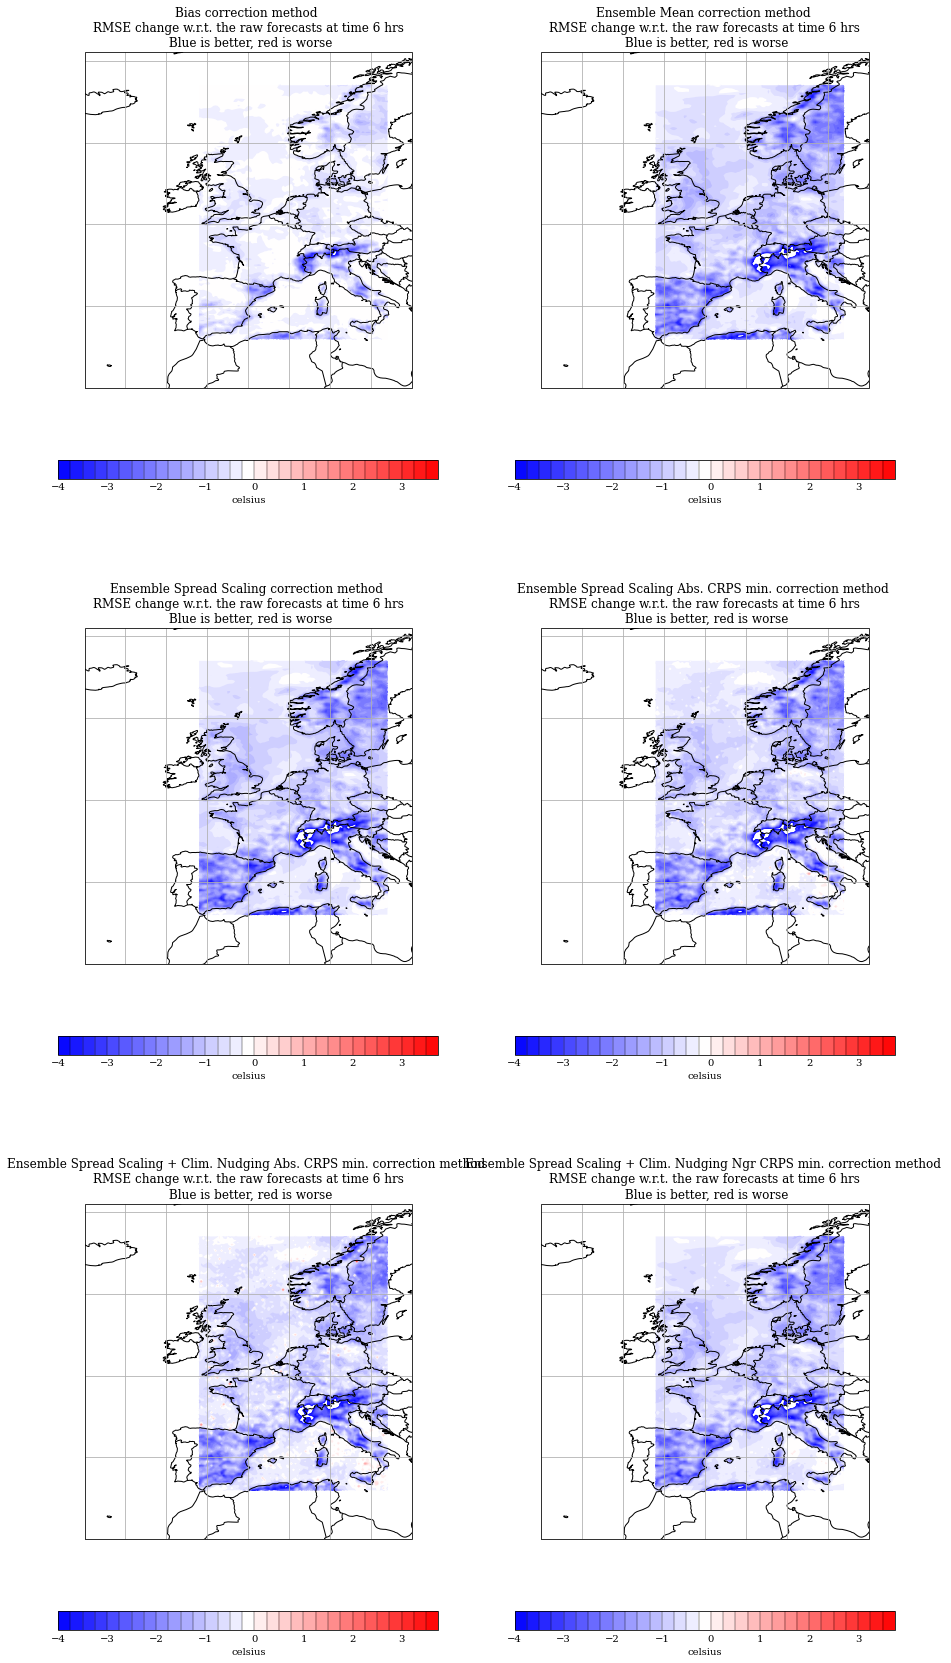

In [35]:
frames = bias_cubes[0].shape[0]
map_proj = ccrs.PlateCarree()
ns = len(rmse_cubes)-1
nr = int(np.ceil(ns / 2))
axls = list()
fig=plt.figure(figsize=(15, 10 * nr))
t = 0
for i in range(ns):
    plt.subplot(nr, 2, i+1, projection=map_proj)
    ax = plt.gca()
    axls.append(ax)
    plot_cube(rmse_cubes[i+1]-rmse_cubes[0], t, t2m_range, ax=ax)
    ax.set_title(exp_labels[i+1]+' method \nRMSE change w.r.t. the raw forecasts at time '+str((t+1)*6)+' hrs\n Blue is better, red is worse')
    
def update(t):
    imlist = list()
    for i in range(ns):
        ax = axls[i]
        ax.clear()
        plot_cube(rmse_cubes[i+1]-rmse_cubes[0], t, t2m_range, ax=ax, quick=False)
        ax.set_title(exp_labels[i+1]+' method \nRMSE change w.r.t. the raw forecasts at time '+str((t+1)*6)+' hrs\n Blue is better, red is worse')
        imlist.append(ax._gci())
    return imlist
            
rmse_anim = animation.FuncAnimation(fig, update, frames=frames, interval=250, blit=False)


Making a video to show the RMSE evolution over the lead time

In [36]:
HTML(rmse_anim.to_html5_video())

Plot of the bias

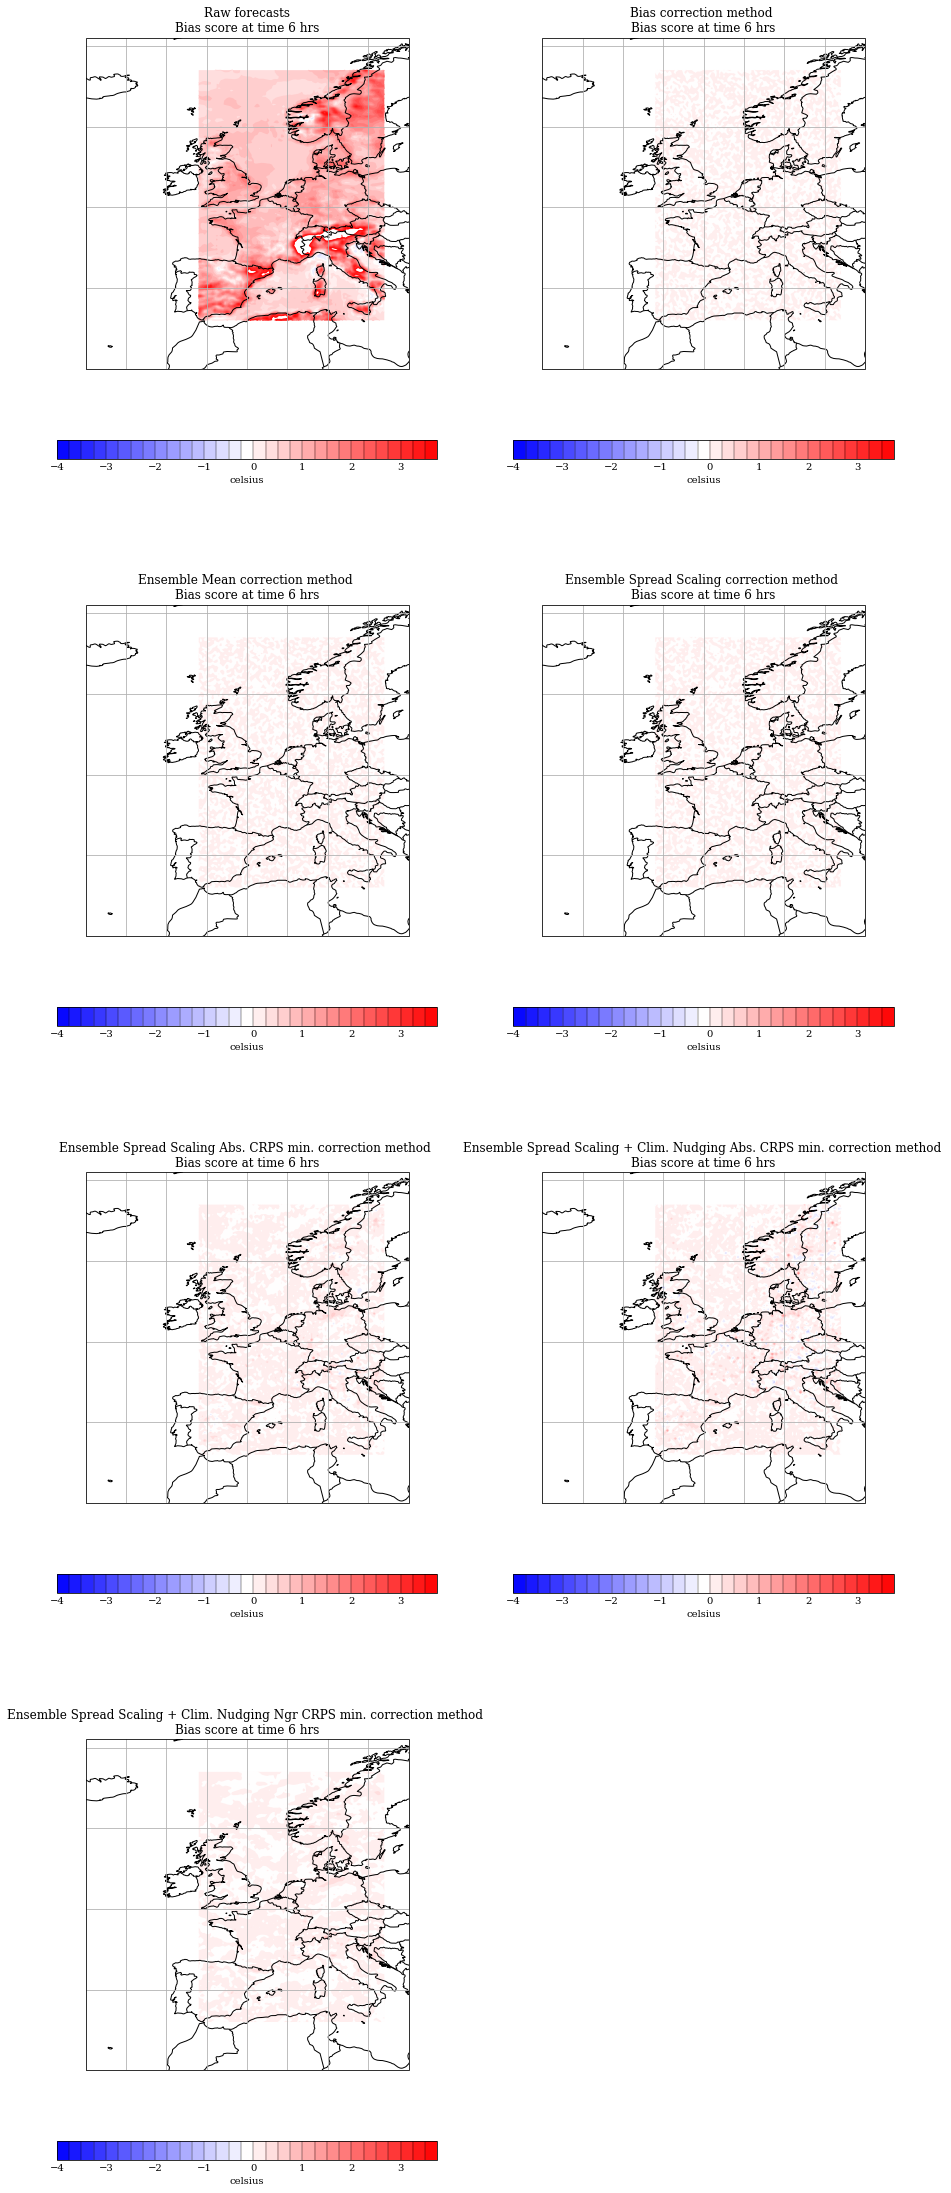

In [37]:
frames = bias_cubes[0].shape[0]
map_proj = ccrs.PlateCarree()
ns = len(bias_cubes)
nr = int(np.ceil(ns / 2))
axls = list()
fig=plt.figure(figsize=(15, 10 * nr))
t = 0
for i in range(ns):
    plt.subplot(nr, 2, i+1, projection=map_proj)
    ax = plt.gca()
    axls.append(ax)
    plot_cube(bias_cubes[i], t, t2m_range, ax=ax)
    if i >= 1: 
        ax.set_title(exp_labels[i]+' method \nBias score at time '+str((t+1)*6)+' hrs')
    else:
        ax.set_title(exp_labels[i]+'\nBias score at time '+str((t+1)*6)+' hrs')

def update(t):
    imlist = list()
    for i in range(ns):
        ax = axls[i]
        ax.clear()
        plot_cube(bias_cubes[i], t, t2m_range, ax=ax, quick=False)
        if i >= 1: 
            ax.set_title(exp_labels[i]+' method \nBias score at time '+str((t+1)*6)+' hrs')
        else:
            ax.set_title(exp_labels[i]+'\nBias score at time '+str((t+1)*6)+' hrs')
        imlist.append(ax._gci())
    return imlist
            
bias_anim = animation.FuncAnimation(fig, update, frames=frames, interval=250, blit=False)


Making a video to show the bias evolution over the lead time

In [38]:
HTML(bias_anim.to_html5_video())